## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

#### Set up Data to be compatible with model

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [2]:
# Parameters
CELL_TYPE = "SHSY5Y"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "LPS_100.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_LPS_100"
SHUFFLE = False

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/regression_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

# set path for nomic data
nomic_df_path = pathlib.Path(
    f"../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{mlp_params.CELL_TYPE}_cleanup4correlation.csv"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()
nomic_df = pd.read_csv(nomic_df_path)

In [5]:
print(df.shape)
df = pd.merge(
    df,
    nomic_df,
    left_on=[
        "Metadata_Well",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    right_on=[
        "Metadata_position_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
).drop(["Metadata_position_x"], axis=1)
print(nomic_df.shape)
print(df.shape)

(597902, 1276)
(154, 190)
(394884, 1463)


In [6]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'LPS_100.000_DMSO_0.025']
The dimensions of the data are: (51630, 1463)
Number of total missing values across all columns: 103260
Data Subset Is Off


In [7]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'B15' 'C15' 'J14' 'I15' 'J15' 'J16' 'J17' 'J20']


In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
# get all columns that contain NSU in the name
df_values_Y = df_values[df_values.columns[df_values.columns.str.contains("NSU")]]
df_values_X = df_values.drop(columns=df_values_Y.columns)
df_values_Y["Metadata_Well"] = df_descriptive["Metadata_Well"]
print(df_values.shape)
print(df_values_X.shape)
print(df_values_Y.shape)

(42667, 1438)
(42667, 1251)
(42667, 188)


/tmp/ipykernel_1234276/682722256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_values_Y['Metadata_Well'] = df_descriptive['Metadata_Well']


#### Split Data - All Models can proceed through this point

In [10]:
X_train, X_test, X_val, Y_train_well, Y_test_well, Y_val_well = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [11]:
Y_train = Y_train_well.drop(columns=["Metadata_Well"])
Y_test = Y_test_well.drop(columns=["Metadata_Well"])
Y_val = Y_val_well.drop(columns=["Metadata_Well"])

In [12]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [13]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = Y_train.shape[1]
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

Number of in features:  1251
Number of out features:  187


In [14]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [15]:
df_values_X.shape
df_values_Y.shape

(42667, 188)

In [16]:
# no accuracy function must be loss for regression
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.METRIC = "loss"
    pass

sampler = optuna.samplers.TPESampler(seed=0)

# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=mlp_params,
    metric=mlp_params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{mlp_params.DIRECTION}", sampler=sampler)
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=mlp_params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=mlp_params,
    metric=mlp_params.METRIC,
    return_info=True,
)

[I 2023-08-24 16:49:23,485] A new study created in memory with name: no-name-bca7624e-ffe7-4c36-b3f6-5ae6944a66d2
[I 2023-08-24 16:49:40,338] Trial 0 finished with value: 0.24172199736535555 and parameters: {'n_layers': 6, 'n_units_l0': 19, 'dropout_0': 0.4616580256429863, 'n_units_l1': 15, 'dropout_1': 0.3541928796033428, 'n_units_l2': 17, 'dropout_2': 0.3625523267576155, 'n_units_l3': 23, 'dropout_3': 0.6781976563006176, 'n_units_l4': 11, 'dropout_4': 0.5750350228495987, 'n_units_l5': 14, 'dropout_5': 0.4408267366563594, 'learning_rate': 0.09256040786288318, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.24172199736535555.
[I 2023-08-24 16:49:56,271] Trial 1 finished with value: 0.0280871027931571 and parameters: {'n_layers': 9, 'n_units_l0': 20, 'dropout_0': 0.6220072889480914, 'n_units_l1': 25, 'dropout_1': 0.5794951385300341, 'n_units_l2': 13, 'dropout_2': 0.5683175057718732, 'n_units_l3': 4, 'dropout_3': 0.48395261279651425, 'n_units_l4': 5, 'dropout_4': 0.666801350229750

Validation Loss: 0.026832429088652136
Training Loss: 0.027360832575176443


(0.026832429088652136, 0.027360832575176443)

In [17]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = pathlib.Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
# if path doesn't exist, make path with pathlib
graph_path.mkdir(parents=True, exist_ok=True)

graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_optimization_history_graph"
fig.write_image(pathlib.Path(f"{graph_path}.png"))
fig.show()

In [18]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = pathlib.Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
# if path doesn't exist, make path with pathlib
graph_path.mkdir(parents=True, exist_ok=True)

graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_intermediate_values_graph"
fig.write_image(pathlib.Path(f"{graph_path}.png"))
fig.show()

In [19]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [20]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    mlp_params,
    mlp_params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 0.027095).  Saving model ...
Epoch 1: Validation loss decreased (0.027095 --> 0.026984).  Saving model ...
Epoch 2: Validation loss decreased (0.026984 --> 0.026927).  Saving model ...
Epoch 3: Validation loss decreased (0.026927 --> 0.026903).  Saving model ...
Epoch 4: Validation loss decreased (0.026903 --> 0.026886).  Saving model ...
Epoch 5: Validation loss decreased (0.026886 --> 0.026874).  Saving model ...
Epoch 6: Validation loss decreased (0.026874 --> 0.026865).  Saving model ...
Epoch 7: Validation loss decreased (0.026865 --> 0.026858).  Saving model ...
Epoch 8: Validation loss decreased (0.026858 --> 0.026853).  Saving model ...
Epoch 9: Validation loss decreased (0.026853 --> 0.026849).  Saving model ...
Epoch 10: Validation loss decreased (0.026849 --> 0.026846).  Saving model ...
Epoch 11: Validation loss decreased (0.026846 --> 0.026843).  Saving model ...
Epoch 12: Validation loss decreased (0.026843 --> 0.026841).  

In [21]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.hyperparameter_optimization/notebooks/../../MLP_utils/utils.py:997: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.hyperparameter_optimization/notebooks/../../MLP_utils/utils.py:998: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



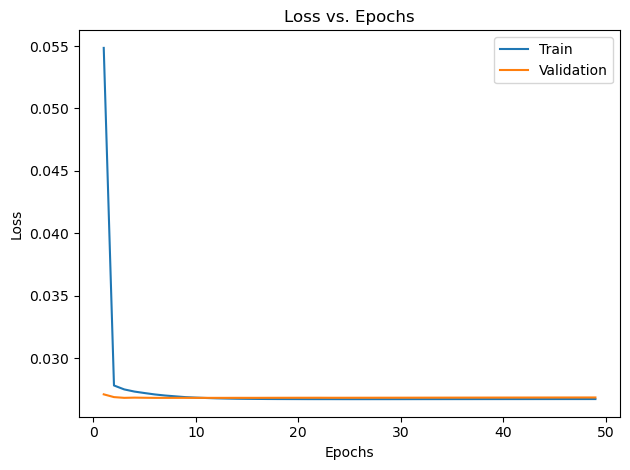

In [22]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

In [23]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    print("yes")
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [24]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(y_pred_list, columns=Y_test.columns, index=Y_test.index)
prediction_df["Metadata_Well"] = Y_test_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()
prediction_df

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Metadata_Well
0,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J20
1,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J16
2,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,C15
3,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J15
4,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I15
4263,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J15
4264,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I15
4265,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,C14


In [25]:
# treatment_col = prediction_df["Metadata_Well"]
# index_dict = {}
# for i in test_col.unique():
#     index_list = []
#     for j in enumerate(test_col):
#         if i == j[1]:
#             index_list.append(j[0])
#     index_dict[i] = index_list
# new_value_dict = {}
# for i in index_dict:
#     new_value_dict[i] = [pred_col[index_dict[i]].median(),treatment_col[index_dict[i]].unique().tolist()[0]]


# df = pd.DataFrame.from_dict(new_value_dict, orient="index").reset_index().rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
# df['cytokine'] = col
# df['model_type'] = "test"

In [26]:
Y_test.head(2)

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
0,0.567975,0.510412,0.258171,0.510877,0.236933,0.306764,0.317715,0.478658,0.529372,0.326632,...,0.215928,0.300473,0.330743,0.648032,0.530266,0.303506,0.359335,0.569729,0.397425,0.388303
1,0.389848,0.662239,0.169720,0.518738,0.445479,0.428729,0.486528,0.480188,0.623475,0.402997,...,0.363074,0.334074,0.558419,0.345332,0.742220,0.307109,0.314524,0.321328,0.615527,0.516639


In [27]:
import matplotlib.pyplot as plt

In [28]:
testing_values = pd.DataFrame(columns=["Actual", "Average Predicted", "cytokine"])

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = Y_test.columns.to_list()
# loop through the columns
for col in Y_test:
    # get the column from test data
    test_col = Y_test[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    mse = mean_squared_error(test_col, pred_col)
    r_square = r2_score(test_col, pred_col)
    a, b = np.polyfit(test_col, pred_col, 1)
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "test"

    testing_values = pd.concat([testing_values, df], axis=0)
    # plt.scatter(df['Actual'], df['Average Predicted'])
    # # plt.plot([min(test_col), max(test_col)], [min(test_col), max(test_col)], color='red', linestyle='--')
    # plt.plot(
    #     test_col,
    #     a * test_col + b,
    #     color="red",
    #     label="R2={0:0.2f}".format(r_square),
    # )
    # plt.title(
    #     f"Regression Nerual Network Prediction vs. True \n {col}", fontsize=25
    # )
    # plt.ylabel("Predicted", fontsize=18)
    # plt.xlabel("Target", fontsize=18)
    # # make data continuous
    # plt.show()
    # plt.close()

In [30]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B14,DMSO_0.100_DMSO_0.025
4281,C14,DMSO_0.100_DMSO_0.025
28619,B15,DMSO_0.100_DMSO_0.025
33133,C15,DMSO_0.100_DMSO_0.025
241180,J14,DMSO_0.100_DMSO_0.025
265463,I15,DMSO_0.100_DMSO_0.025
270183,J15,DMSO_0.100_DMSO_0.025
293850,J16,LPS_100.000_DMSO_0.025
309750,J17,LPS_100.000_DMSO_0.025
344551,J20,LPS_100.000_DMSO_0.025


In [31]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [32]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.567975,0.553127,Activin A [NSU],J20,test,LPS_100.000_DMSO_0.025
1,0.389848,0.553127,Activin A [NSU],J16,test,LPS_100.000_DMSO_0.025
2,0.468110,0.553127,Activin A [NSU],C15,test,DMSO_0.100_DMSO_0.025
3,0.442153,0.553127,Activin A [NSU],J15,test,DMSO_0.100_DMSO_0.025
4,0.601907,0.553127,Activin A [NSU],J17,test,LPS_100.000_DMSO_0.025
...,...,...,...,...,...,...
1865,0.763760,0.554708,XCL1 (Lymphotactin) [NSU],B14,test,DMSO_0.100_DMSO_0.025
1866,0.657983,0.554708,XCL1 (Lymphotactin) [NSU],I15,test,DMSO_0.100_DMSO_0.025
1867,0.298807,0.554708,XCL1 (Lymphotactin) [NSU],B15,test,DMSO_0.100_DMSO_0.025
1868,0.430975,0.554708,XCL1 (Lymphotactin) [NSU],J14,test,DMSO_0.100_DMSO_0.025


# Hold out

In [33]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [34]:
# get all columns that contain NSU in the name
df_values_Y = df_values[df_values.columns[df_values.columns.str.contains("NSU")]]
df_values_X = df_values.drop(columns=df_values_Y.columns)
df_values_Y["Metadata_Well"] = df_descriptive["Metadata_Well"]

print(df_values.shape)
print(df_values_X.shape)
print(df_values_Y.shape)

(8963, 1438)
(8963, 1251)
(8963, 188)


/tmp/ipykernel_1234276/872919022.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
df_values_Y_well = df_values_Y
df_values_Y = df_values_Y.drop(columns=["Metadata_Well"])

In [36]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [37]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [38]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(
    y_pred_list, columns=df_values_Y.columns, index=df_values_Y.index
)
prediction_df.head(2)

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
236343,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.401412,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708
236344,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.401412,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708


In [39]:
print(df_values_Y.shape, prediction_df.shape)
df_values_Y.head(2)
prediction_df.head(2)

(8963, 187) (8963, 187)


,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,TWEAK [NSU],uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU]
236343,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.401412,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708
236344,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.401412,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708


In [40]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(
    y_pred_list, columns=df_values_Y.columns, index=df_values_Y.index
)
prediction_df["Metadata_Well"] = df_values_Y_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()
prediction_df

,Activin A [NSU],AITRL (GITR Ligand) [NSU],Amphiregulin [NSU],Amyloid beta [NSU],APRIL [NSU],BAFF [NSU],BCMA (TNFRSF17) [NSU],BDNF [NSU],BMP2 [NSU],BMP3 [NSU],...,uPA [NSU],VCAM-1 [NSU],VEGF Receptor 2 (Flk-1) [NSU],VEGF-A (165) [NSU],VEGF-C [NSU],VEGF-D [NSU],VEGFR-1 [NSU],WISP-1 (CCN4) [NSU],XCL1 (Lymphotactin) [NSU],Metadata_Well
236343,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I14
236344,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I14
236345,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I14
236346,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I14
236347,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,I14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363387,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J21
363388,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J21
363389,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J21
363390,0.553127,0.672684,0.263708,0.548435,0.581517,0.409187,0.491697,0.472798,0.647211,0.526138,...,0.192506,0.438773,0.398925,0.465677,0.287587,0.400124,0.600639,0.516713,0.554708,J21


In [41]:
df_values_Y.reset_index(drop=True, inplace=True)
prediction_df.reset_index(drop=True, inplace=True)

In [42]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = df_values_Y.columns.to_list()
# loop through the columns
for col in test_data_columns:
    # get the column from test data
    test_col = df_values_Y[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    mse = mean_squared_error(test_col, pred_col)
    r_square = r2_score(test_col, pred_col)
    a, b = np.polyfit(test_col, pred_col, 1)
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "holdout"

    testing_values = pd.concat([testing_values, df], axis=0)
    # plt.scatter(df['Actual'], df['Average Predicted'])
    # # plt.plot([min(test_col), max(test_col)], [min(test_col), max(test_col)], color='red', linestyle='--')
    # plt.plot(
    #     test_col,
    #     a * test_col + b,
    #     color="red",
    #     label="R2={0:0.2f}".format(r_square),
    # )
    # plt.title(
    #     f"Regression Nerual Network Prediction vs. True \n {col}", fontsize=25
    # )
    # plt.ylabel("Predicted", fontsize=18)
    # plt.xlabel("Target", fontsize=18)
    # # make data continuous
    # plt.show()
    # plt.close()

In [43]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
236343,I14,DMSO_0.100_DMSO_0.025
359266,J21,LPS_100.000_DMSO_0.025


In [44]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [45]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y
0,0.567975,0.553127,Activin A [NSU],J20,test,LPS_100.000_DMSO_0.025,NaN
1,0.389848,0.553127,Activin A [NSU],J16,test,LPS_100.000_DMSO_0.025,NaN
2,0.468110,0.553127,Activin A [NSU],C15,test,DMSO_0.100_DMSO_0.025,NaN
3,0.442153,0.553127,Activin A [NSU],J15,test,DMSO_0.100_DMSO_0.025,NaN
4,0.601907,0.553127,Activin A [NSU],J17,test,LPS_100.000_DMSO_0.025,NaN
...,...,...,...,...,...,...,...
2239,0.447870,0.600639,VEGFR-1 [NSU],J21,holdout,NaN,LPS_100.000_DMSO_0.025
2240,0.757655,0.516713,WISP-1 (CCN4) [NSU],I14,holdout,NaN,DMSO_0.100_DMSO_0.025
2241,0.491146,0.516713,WISP-1 (CCN4) [NSU],J21,holdout,NaN,LPS_100.000_DMSO_0.025
2242,0.432246,0.554708,XCL1 (Lymphotactin) [NSU],I14,holdout,NaN,DMSO_0.100_DMSO_0.025


In [48]:
# combine two columns into one oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x and oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y
testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = testing_values[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x"
].fillna(testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y"])
testing_values.drop(
    columns=[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y",
    ],
    inplace=True,
)
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.567975,0.553127,Activin A [NSU],J20,test,LPS_100.000_DMSO_0.025
1,0.389848,0.553127,Activin A [NSU],J16,test,LPS_100.000_DMSO_0.025
2,0.468110,0.553127,Activin A [NSU],C15,test,DMSO_0.100_DMSO_0.025
3,0.442153,0.553127,Activin A [NSU],J15,test,DMSO_0.100_DMSO_0.025
4,0.601907,0.553127,Activin A [NSU],J17,test,LPS_100.000_DMSO_0.025
...,...,...,...,...,...,...
2239,0.447870,0.600639,VEGFR-1 [NSU],J21,holdout,LPS_100.000_DMSO_0.025
2240,0.757655,0.516713,WISP-1 (CCN4) [NSU],I14,holdout,DMSO_0.100_DMSO_0.025
2241,0.491146,0.516713,WISP-1 (CCN4) [NSU],J21,holdout,LPS_100.000_DMSO_0.025
2242,0.432246,0.554708,XCL1 (Lymphotactin) [NSU],I14,holdout,DMSO_0.100_DMSO_0.025
